In [147]:
import torch
import matplotlib.pyplot as plt
import os
import imageio
import datasets.toy_datasets as datasets
import utils.sde_lib as SDEs
from utils.models import MatrixTimeEmbedding, MLP
from utils.model_utils import get_preconditioned_model
from utils.metrics import get_w2
from ema_pytorch import EMA

torch.set_printoptions(precision=4,sci_mode=False)

In [148]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dataset = datasets.Spiral(1000, x_scalar=0.4 * 2, y_scalar=3.2 * 2)

In [157]:
@torch.no_grad()
def measure_straightness(sde, trajectories):
    start, end = trajectories[:,0], trajectories[:,-1]
    diff = end - start
    straightness = 0
    n_pts =trajectories.shape[1]
    dt = sde.T/n_pts

    time_pts = sde.T - torch.linspace(0., sde.T, n_pts, device=device)
    one = torch.ones(start.shape[0],device=start.device)
    for i in range(n_pts-1):
        drift = sde.probability_flow_drift(trajectories[:,i+1], one * (time_pts[i]))
        val = diff-drift
        # val = val[:,:2]
        straightness += torch.mean(torch.sum((val)**2,dim=-1),dim=0)
    
    return straightness * dt #/(trajectories.shape[-1])


def plot_trajectories(traj, save_path, gif_name='trajectories.gif'):
    idx = range(traj.shape[1])
    file_names = [os.path.join(save_path,f'{i}.png') for i in idx]
    dt = 1/(traj.shape[1]-1)
    
    for i in idx:
        fig, ax = plt.subplots(1,1,figsize=(6,6))
        
        ax.title(f't = {dt * i : .2f}')
        ax.grid(zorder=0)
        ax.scatter(traj[:,i,0].detach().cpu(), traj[:,i,1].detach().cpu())
        ax.set_xlim(traj.cpu().min()-0.5, traj.cpu().max()+0.5)
        ax.set_ylim(traj.cpu().min()-0.5, traj.cpu().max()+0.5)

        ax.savefig(file_names[i])
        plt.close(fig)
    with imageio.get_writer(gif_name, mode='I', duration=0.05) as writer:
        for filename in file_names:
            image = imageio.imread(filename)
            writer.append_data(image)

    # Optional: Clean up the temporary files
    # for filename in file_names:
    #     os.remove(filename)

def plot_lines(traj, dim1,dim2,filename):
    fig, ax = plt.subplots(1,1,figsize=(6,6))

    ax.grid(True, linestyle='--', linewidth=0.5)
    for i in range(traj.shape[0]):
        xi = traj[i]
        ax.plot(xi[:,dim1].cpu(), xi[:,dim2].cpu(), linewidth=1, alpha=.3)

    # ax.scatter(traj[:,0,0].cpu(), traj[:,0,1].cpu(), label='start',zorder=1010, cmap='viridis', s=10, alpha=0.75)
    ax.scatter(traj[:,-1:,dim1].cpu(), traj[:,-1,dim2].cpu(),label='end', cmap='viridis', s=10, alpha=0.75)
    ax.set_xlim(traj[...,dim1].cpu().min()-0.5, traj[...,dim1].cpu().max()+0.5)
    ax.set_ylim(traj[...,dim2].cpu().min()-0.5, traj[...,dim2].cpu().max()+0.5)

    ax.legend()
    fig.savefig(filename,facecolor='none', edgecolor='none', transparent=True)
    plt.close(fig)

In [150]:
# SB 
method_names = ['vp','cld','vsdm','mom']
model_paths = [
    'checkpoints/vp_spiral_7.5/itr_100000/',
    'checkpoints/cld_spiral_7.5/itr_100000/',
    'checkpoints/vsdm_spiral_7.5/itr_100000/',
    'checkpoints/mom_spiral_7.5/itr_100000/'
]

sdes = [SDEs.VP(), 
        SDEs.CLD(), 
        SDEs.LinearSchrodingerBridge(), 
        SDEs.LinearMomentumSchrodingerBridge()
    ]


for path, sde in zip(model_paths,sdes):
    if isinstance(sde,(SDEs.LinearMomentumSchrodingerBridge, SDEs.LinearSchrodingerBridge)):
        forward_score  = EMA(MatrixTimeEmbedding([4 if sde.is_augmented else 2]).to(device))
        forward_score.load_state_dict(torch.load(os.path.join(path,'forward_ema.pt')))
        sde.forward_score = forward_score
        print([param for param in forward_score.parameters()])
    
    backwards_score = MLP(2,sde.is_augmented).to(device)
    backwards_score.load_state_dict(torch.load(os.path.join(path,'backward.pt')))
    sde.backward_score = get_preconditioned_model(backwards_score,sde)

[Parameter containing:
tensor([-0.4900, -0.2348], device='cuda:0', requires_grad=True), Parameter containing:
tensor([-0.5146, -0.2294], device='cuda:0')]
[Parameter containing:
tensor([-0.0001, -0.0049,  0.0465,  0.0099], device='cuda:0',
       requires_grad=True), Parameter containing:
tensor([ 0.0092, -0.0047,  0.0484,  0.0095], device='cuda:0')]


In [162]:
n_samples = 100
samples = []
trajectories = []

for sde in sdes:
    dim = 4 if sde.is_augmented else 2
    xt, traj = sde.sample((n_samples,dim),device,prob_flow=False,return_traj=True,n_time_pts=100)
    samples.append(xt)
    trajectories.append(traj)

/tmp/ipykernel_229202/3716145060.py:54: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(traj[:,-1:,dim1].cpu(), traj[:,-1,dim2].cpu(),label='end', cmap='viridis', s=10, alpha=0.75)


W2 cld 19.49046516418457
Straightness cld 4155.248046875
W2 mom 18.157424926757812
Straightness mom 3881.13232421875


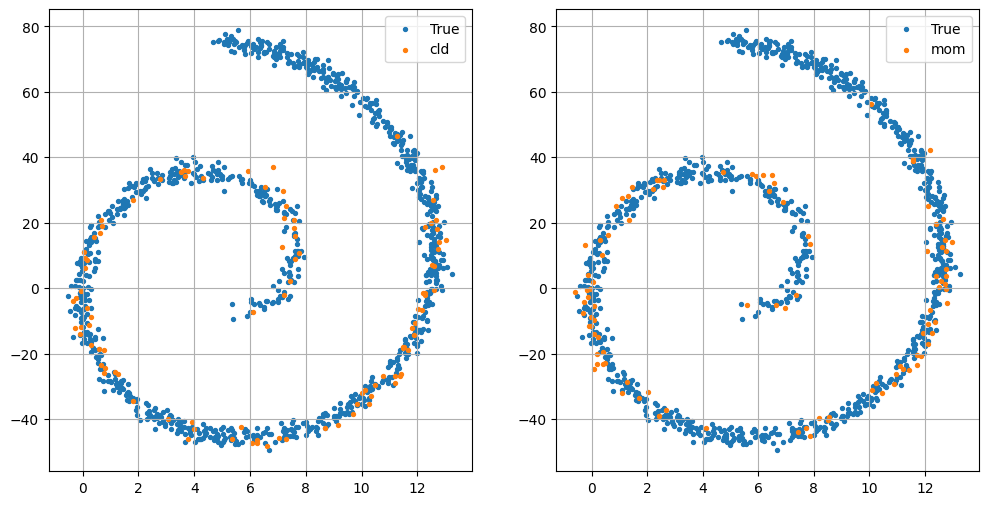

In [163]:
# Comparison with CLD for non isotropic datasets

true = next(dataset).to(device)

fig, ax = plt.subplots(1,2,figsize=(12,6))
k = 0
for i,sample in enumerate(samples):
    if sdes[i].is_augmented:
        ax[k].scatter(true[:,0].cpu(),true[:,1].cpu(),s=8,label='True')
        ax[k].scatter(sample[:,0].cpu(),sample[:,1].cpu(),s=8,label=method_names[i])
        ax[k].grid()
        ax[k].legend()
        
        k+=1
        # ax.scatter(traj[:,i,0].cpu(),traj[:,i,1].cpu(),s=8,label=f'noise {method_names[i]}')
        plot_lines(trajectories[i],0,1,f'trajectory/lines_x_{method_names[i]}')
        plot_lines(trajectories[i],2,3,f'trajectory/lines_v_{method_names[i]}')
        
        print(f'W2 {method_names[i]} {get_w2(sample,true)}')
        print(f'Straightness {method_names[i]} {measure_straightness(sdes[i],trajectories[i])}')
    else:
        plot_lines(trajectories[i],0,1,f'trajectory/lines_x_{method_names[i]}')
        